In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sys

In [2]:
from easydict import EasyDict
cfg = EasyDict()
cfg.SEQ_LENGTH = 250
cfg.TILE_SIZE = 7
cfg.OUT_SIZE = 1
cfg.TRAIN = EasyDict()
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_SIZE = 1000
cfg.TRAIN.EPOCH_NUM = 10
cfg.gm_num = 4
cfg.ndim = 6
cfg.NAME = 'conv_ndim%i'%(cfg.ndim)#'conv_net_no_bn_ndim12010'#

In [3]:
from loader import TieLoader,data_generator
train_loader = TieLoader('/home/nvvaulin/development/dataset/train_ties1',
                         0.2,0.3,t_size=32,mask_size=cfg.OUT_SIZE,sample_size=cfg.TILE_SIZE)
test_loader = TieLoader('/home/nvvaulin/development/dataset/test_ties',
                        0.2,0.3,t_size=32,mask_size=cfg.OUT_SIZE,sample_size=cfg.TILE_SIZE)

reading images 1541 99 
reading images 175 99 


204.0 52.0


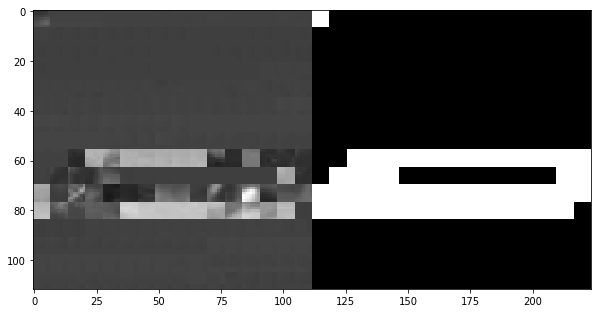

In [4]:
from dataset_tools import draw

for x,y in data_generator(train_loader,epoch_size=1,shuffle=True):
    print np.ones_like(y)[y<0.1].sum(),np.ones_like(y)[y>0.9].sum()
    x = np.transpose(x,(0,2,3,1)).astype(np.uint8)
    y = (y*255.).astype(np.uint8)
    _y = np.zeros(x.shape[:3],dtype=np.uint8)
    _y[:] = y[:,0,0][:,None,None]
    draw(x,_y)

In [5]:
import theano
import theano.tensor as T

/usr/local/lib/python2.7/dist-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


# Build model

In [6]:
from lasagne import layers as L
from lasagne.nonlinearities import rectify
from utils import NormedDense,L2NormLayer
from utils import get_network_str,save_weights,load_weights
import lasagne

def conv(data,num_filters,name,pad):
    return L.Conv2DLayer(data,filter_size=(3,3),num_filters=num_filters,
                        nonlinearity=None,pad=pad,
                        name='conv_'+name) 

def conv_nonl(data,num_filters,name,pad):
    res = conv(data,num_filters,name,pad=pad)
    res = L.BatchNormLayer(res,name='bn_'+name,alpha=0.05)
    res = L.NonlinearityLayer(res,rectify,name='relu_'+name) 
    return res

def FCN(data,ndim,verbose=True,model_name='',input_shape = (None,3,None,None),pad='same'):
    datal = res = L.InputLayer(input_shape
                           ,data/256.
                           ,name='data')
    res = conv_nonl(res,6,'1',pad= pad)
    res = conv_nonl(res,12,'2',pad=pad)
    res = conv(res,12,'3',pad=pad)
    res = L.DimshuffleLayer(res,(0,2,3,1),name='transpose')
    res = L2NormLayer(res,1e-8,name='l2norm')
    res = NormedDense(res,ndim,epsilon=1e-5,name="normedDense")
    if(model_name!=''):
        load_weights(res,'models/'+model_name)
    print get_network_str(res,incomings=True,outgoings=True)
    return res
        
def soft_predict_sym(features,means,covars,weights):
    return 1.-T.nnet.sigmoid(calc_log_prob_gmm(features,means,covars,weights))

data = T.tensor4(name='data')
label = T.tensor3(name='label')
net = FCN(data,ndim=cfg.ndim,model_name='',input_shape = (None,3,cfg.TILE_SIZE,cfg.TILE_SIZE),pad = 'valid')


In -->     Layer    --> Out    Description               
-------    -----    -------    -----------               
[]         0        [1]        data(None, 3, 7, 7)       
[0]        1        [2]        conv_1(None, 6, 5, 5)     
[1]        2        [3]        bn_1(None, 6, 5, 5)       
[2]        3        [4]        relu_1(None, 6, 5, 5)     
[3]        4        [5]        conv_2(None, 12, 3, 3)    
[4]        5        [6]        bn_2(None, 12, 3, 3)      
[5]        6        [7]        relu_2(None, 12, 3, 3)    
[6]        7        [8]        conv_3(None, 12, 1, 1)    
[7]        8        [9]        transpose(None, 1, 1, 12) 
[8]        9        [10]       l2norm(None, 1, 1, 13)    
[9]        10       []         normedDense(None, 1, 1, 6)


# Train

In [7]:
from gmm_op import get_gmm,calc_log_prob_gmm
from theano_utils import split,histogram_loss

def split_tr_p_n(x,y):
    x_tr_p,x_n = split(x,y)
    x_p = x_tr_p[x_tr_p.shape[0]//2:]
    x_tr = x_tr_p[:x_tr_p.shape[0]//2]
    return x_tr,x_p,x_n

def make_classifier(X,label,non_learn_params):
    X = X.reshape((-1,X.shape[-1]))
    x_tr,x_p,x_n = split_tr_p_n(X,label.flatten())
    m,c,w = get_gmm(x_tr,cfg.gm_num,cfg.ndim,use_approx_grad=True)
    p_n = calc_log_prob_gmm(x_n,m,c,w)
    p_p = calc_log_prob_gmm(x_p,m,c,w)
    loss = histogram_loss(p_n,p_p,
                          non_learn_params['min_cov'],
                          100,
                          non_learn_params['width'])[0]
    prediction = T.nnet.sigmoid(T.concatenate([p_p,p_n],axis=0))
    Y = T.concatenate([T.ones_like(p_p),T.zeros_like(p_n)],axis=0)
    return loss,X,Y,prediction,m,c,w,p_p,p_n

def make_train(net,data,label,non_learn_params):
    sym = L.get_output(net ,determenisic=False)
    loss,X,Y,prediction,m,c,w,p_p,p_n = make_classifier(sym,label,non_learn_params)
    params = L.get_all_params(net,trainable=True)
    updates = lasagne.updates.adam(loss,params,non_learn_params['lr'])
    return theano.function([data, label], [loss,X,Y,prediction,m,c,w],\
                               allow_input_downcast=True, updates=updates)


def make_test(net,data,label,non_learn_params):
    sym = L.get_output(net ,determenisic=True)
    loss,X,Y,prediction,m,c,w,p_p,p_n = make_classifier(sym,label,non_learn_params)
    return theano.function([data, label], [loss,X,Y,prediction,m,c,w],\
                               allow_input_downcast=True)
        

non_learn_params={'min_cov' : theano.shared(1e-3),
                  'lr' : theano.shared(np.array(1e-2, dtype=theano.config.floatX)),
                  'width': theano.shared(2.)}

train_fn = make_train(net,data,label,non_learn_params)
print 'train_fn compiled'
test_fn = make_test(net,data,label,non_learn_params)
print 'test_fn compiled'

/home/nvvaulin/.local/lib/python2.7/site-packages/lasagne/layers/helper.py:209: UserWarning: get_output() was called with unused kwargs:
	determenisic (perhaps you meant deterministic)
  % "\n\t".join(suggestions))


train_fn compiled
test_fn compiled


In [8]:
from sklearn.metrics import average_precision_score


def get_pp_pn(l,pred):
    o = np.ones(len(l))
    pn = []
    pp = []
    R = pred[::max(len(pred)//100,1)].copy()
    R  = np.sort(R)
    for r in R:
        pn.append(o[(pred > r)&(l>0.9)].sum()/o[l>0.9].sum())
        pp.append(o[(pred < r)&(l<0.1)].sum()/o[l<0.1].sum())
    pp,pn = np.array(pp),np.array(pn)
    return (np.abs(pn[1:]-pn[:-1])*(pp[1:]+pp[:-1])/2.).sum()

def iterate_batches(fn,data_generator,epoch,metrix = dict()):
    loss=0
    acc=0
    labels,predicted = np.array([]),np.array([])
    for i,batch in enumerate(data_generator()):        
        res = fn(*batch)
        mask = (res[2]>0.9) | (res[2]<0.1)
        loss+=res[0]
        labels = np.concatenate((labels,res[2][mask]))
        predicted = np.concatenate((predicted,res[3][mask]))
    s = ' '.join(['%s=%.3f'%(k,metrix[k](labels,predicted)) for k in metrix.keys() ])
    if(i%1000 == 0 ):
        print '\r epoch %i batch %i loss=%.2f l=%.2f %s     '%\
        (epoch,i,loss/float(i+1),res[0],s)
        sys.stdout.flush()        
    print '\r epoch %i batch %i loss=%.2f l=%.2f %s     '%\
    (epoch,i,loss/float(i+1),res[0],s)
    sys.stdout.flush()

metrix = { 'aps' : average_precision_score,
           'pp'  : lambda l,pred : np.ones(len(l))[(pred < 0.5)&(l<0.1)].sum()/np.ones(len(l))[l<0.1].sum(),
           'pn'  : lambda l,pred : np.ones(len(l))[(pred >= .5)&(l>0.9)].sum()/np.ones(len(l))[l>0.9].sum(),
           'int_pp_pn' : lambda l,pred : get_pp_pn(l,pred)}

def update_params(epoch,params):
    if(epoch == 0):
        params['min_cov'].set_value(1e-8)
        #params['p_n_weight'].set_value(1e1)
        params['lr'].set_value(1e-3)
    
def fit(name,
        net,
        train_fn,test_fn,
        train_loader,test_loader,
        non_learn_params,
        epochs=3,train_esize=1500,test_esize=750,
        metrix = metrix,update_params = update_params):
    for j in range(0,epochs):
        update_params(j,non_learn_params)
        print('train')
        sys.stdout.flush()
        iterate_batches(train_fn,\
                        lambda : data_generator(train_loader,epoch_size=train_esize,shuffle=True),
                       j,metrix)
        save_weights(net,'models/%s%03d'%(name,j))
        print('test')
        sys.stdout.flush()
        iterate_batches(test_fn,\
                        lambda : data_generator(test_loader,epoch_size=test_esize,shuffle=True),
                       j,metrix)

        
# iterate_batches(test_fn,\
#             lambda : data_generator(test_loader,epoch_size=750,shuffle=True),
#           -1,metrix)
fit(cfg.NAME,net,train_fn,test_fn,train_loader,test_loader,non_learn_params,epochs=6)

train
 epoch 0 batch 1499 loss=86.29 l=67.28 aps=0.990 pp=0.982 pn=0.826 int_pp_pn=0.978     
checkpoint models/conv_ndim6000.npz
test
 epoch 0 batch 749 loss=201.32 l=0.00 aps=0.982 pp=0.974 pn=0.768 int_pp_pn=0.961     
train
 epoch 1 batch 1499 loss=69.93 l=66.51 aps=0.992 pp=0.988 pn=0.823 int_pp_pn=0.983     
checkpoint models/conv_ndim6001.npz
test
 epoch 1 batch 749 loss=211.51 l=1731.71 aps=0.980 pp=0.974 pn=0.766 int_pp_pn=0.955     
train
 epoch 2 batch 1499 loss=89.99 l=0.00 aps=0.988 pp=0.981 pn=0.820 int_pp_pn=0.975     
checkpoint models/conv_ndim6002.npz
test
 epoch 2 batch 749 loss=201.42 l=0.00 aps=0.984 pp=0.974 pn=0.783 int_pp_pn=0.967     
train
 epoch 3 batch 1499 loss=67.56 l=0.00 aps=0.991 pp=0.989 pn=0.821 int_pp_pn=0.980     
checkpoint models/conv_ndim6003.npz
test
 epoch 3 batch 749 loss=151.05 l=7.76 aps=0.986 pp=0.976 pn=0.803 int_pp_pn=0.970     
train
 epoch 4 batch 1499 loss=62.90 l=0.00 aps=0.991 pp=0.986 pn=0.825 int_pp_pn=0.981     
checkpoint models/

In [46]:
print params[0].get_value()

[ 0.10446833  0.0588083  -0.18264511]


In [ ]:
rain
 epoch 5 batch 1499 loss=300.85 l=208.09 aps=0.993 pp=0.990 pn=0.808 int_pp_pn=0.985     
checkpoint models/conv_ndim4005.npz
test
 epoch 5 batch 749 loss=966.51 l=212.37 aps=0.988 pp=0.980 pn=0.784 int_pp_pn=0.958       

train
 epoch 0 batch 1499 loss=467.20 l=0.00 aps=0.990 pp=0.979 pn=0.825 int_pp_pn=0.980     
checkpoint models/conv_ndim4000.npz
test
 epoch 0 batch 749 loss=782.77 l=878.09 aps=0.987 pp=0.979 pn=0.779 int_pp_pn=0.965     
train
 epoch 1 batch 1499 loss=357.55 l=0.00 aps=0.992 pp=0.987 pn=0.807 int_pp_pn=0.961     
checkpoint models/conv_ndim4001.npz
test
 epoch 1 batch 749 loss=805.39 l=0.00 aps=0.985 pp=0.989 pn=0.735 int_pp_pn=0.919     
train
 epoch 2 batch 1499 loss=312.71 l=252.80 aps=0.992 pp=0.990 pn=0.797 int_pp_pn=0.967     
checkpoint models/conv_ndim4002.npz
test
 epoch 2 batch 749 loss=844.21 l=0.00 aps=0.986 pp=0.984 pn=0.760 int_pp_pn=0.968     
train
In [46]:


In [25]:
for i,batch in enumerate(data_generator(test_loader,epoch_size=100,shuffle=False)):
    res = test_fn(*batch)
    if(i == 0):
        p =res[-1]
        n = res[-2]
    p = np.concatenate((p,res[-1]))
    n = np.concatenate((n,res[-2]))
    

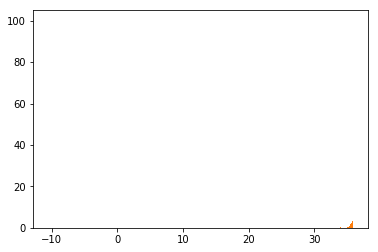

In [19]:
plt.hist(np.clip(res[-1],-10,100),100,normed=True)
plt.hist(np.clip(res[-2],-10,100),100,normed=True)
plt.show()

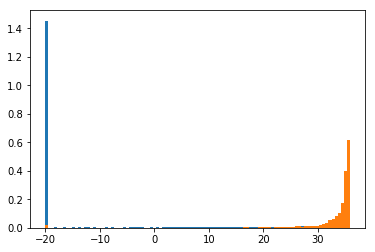

In [28]:
plt.hist(np.clip(p,-20,100),100,normed=True)
plt.hist(np.clip(n,-20,100),100,normed=True)
plt.show()

# Evaluate model

In [28]:
data=T.tensor4()
feature_sym = FCN(data,cfg.ndim,model_name='',input_shape=(cfg.SEQ_LENGTH,3,cfg.TILE_SIZE,cfg.TILE_SIZE))[1]
feature_fn = theano.function([data],feature_sym,allow_input_downcast=True)


In -->     Layer    --> Out    Description           
-------    -----    -------    -----------           
[]         0        [1]        data(250, 3, 16, 16)  
[0]        1        [2]        bn0(250, 3, 16, 16)   
[1]        2        [3]        conv1(250, 12, 16, 16)
[2]        3        [4]        bn1(250, 12, 16, 16)  
[3]        4        [5]        nonl1(250, 12, 16, 16)
[4]        5        [6]        conv2(250, 24, 16, 16)
[5]        6        [7]        bn2(250, 24, 16, 16)  
[6]        7        [8]        nonl2(250, 24, 16, 16)
[7]        8        [9]        3(250, 3, 16, 16)     
[8]        9        []         3(250, 3, 16, 16)     


In [30]:
d = np.zeros((cfg.SEQ_LENGTH,3,cfg.TILE_SIZE,cfg.TILE_SIZE),dtype=np.float32)
d[0,2,:,:] = 1
d = feature_fn(d)

In [32]:
print d.shape

(250, 16, 16, 4)


In [19]:
from dataset_tools import *
from gmm_bg_substructor import BgSubstructor
import cv2
import numpy as np
# params = { 'algorithm': 'grimson_gmm', 
#             'low': 1.,#*24*24,
#             'high': 3,#.*24*24,
#             'alpha': 0.01,
#             'max_modes': 5,
#             'channels': 12,
#             'variance': .01,
#             'bg_threshold': 0.075,
#             'min_variance': .005,
#             'variance_factor': 1.}


In [20]:
def make_bgs_test(feature_fn,params,out_name=cfg.NAME,dataset='test_dataset',max_l = 1000,im_size=None,verbose=False,skip_frames=200):
    def make_bgs_features(feature_fn,x):
        return feature_fn(np.transpose(x,(0,3,1,2)))[0]
    out_dir = 'results/'+out_name+'_'+params['algorithm']
    if(not os.path.exists(out_dir)):
        os.mkdir(out_dir)
    f = open('params.txt','w')
    f.write('params\n'+str(params)+'\n')
    f.write('max_l = %i,skip_frames=%i')
    f.close()
    jj = 0
    try:
        for d_in,d_out in iterate_folders(dataset,out_dir):
            jj+=1
            if(jj<1):
                continue
            try:
                bgs = BgSubstructor(params)
                i = 0
                prev =None
                for im,mask in iterate_video(d_in,skip_first_unlabled=True):
                    print '%s %d                   \r'%(d_in,i),
                    if not (im_size is None):
                        im,mask = resize(im,mask,im_size)
                    if(prev is None):
                        prev = im
                        continue
                    #tmp = np.concatenate((im[np.newaxis],prev[np.newaxis]),0)
                    features = make_bgs_features(feature_fn,im.astype(np.float32))
                    prev = im
                    pred = bgs.update(features.astype(np.float32),im.astype(np.float32))
                    cv2.imwrite(d_out+'/%d.png'%(i),pred)
                    cv2.imwrite(d_out+'/%d_true.png'%(i),mask)
                    cv2.imwrite(d_out+'/%d_input.png'%(i),im)
                    if(verbose):
                        cv2.imshow('pred',pred)
                        cv2.imshow('true',mask)
                        cv2.imshow('input',im)
                        cv2.waitKey(1)
                    if(i >= max_l):
                        break
                    i+=1
                print '%s %d\r'%(d_in,i),
            finally:
                del bgs
    finally:
        if(verbose):
            cv2.destroyAllWindows()
    print 'done'

In [30]:
params = { 
    'algorithm': 'FTSG', 
    'th': 30, 
    'nDs': 5,
    'nDt': 5,
    'nAs': 5,
    'nAt': 5,
    'bgAlpha': 0.004,
    'fgAlpha': 0.05,
    'tb': 15,
    'tf': 0.00001,
    'tl': 0.01,
    'init_variance' : 0.01
} 
make_bgs_test(feature_fn,
               out_name=cfg.NAME,
               params=params,
               dataset='../gmm_segmentation/test_dataset',
               im_size=(320,240),
               verbose=True)

delete bgsmentation/test_dataset/badWeather/blizzard 1000                   
delete bgsmentation/test_dataset/baseline/highway 162                   


KeyboardInterrupt: 

In [20]:
params = { 
    'algorithm': 'FTSG', 
    'th': 30, 
    'nDs': 5,
    'nDt': 5,
    'nAs': 5,
    'nAt': 5,
    'bgAlpha': 0.004,
    'fgAlpha': 0.5,
    'tb': 4,
    'tf': 20,
    'tl': 0.1,
    'init_variance': 15
}
make_bgs_test(lambda x : np.transpose(x,(0,2,3,1)),
               params,
               out_name='baseline',
               dataset='../gmm_segmentation/test_dataset',
               im_size=(320,240),
               verbose=True)

delete bgsmentation/dataset/badWeather/skating 1000                   
delete bgsmentation/dataset/badWeather/snowFall 1000                   
delete bgsmentation/dataset/badWeather/wetSnow 0                   
delete bgsmentation/dataset/baseline/office 1000                   
delete bgsmentation/dataset/baseline/pedestrians 799                   
delete bgsmentation/dataset/baseline/PETS2006 223                   


KeyboardInterrupt: 

In [45]:
data,m,c,w=T.matrix(),T.matrix(),T.matrix(),T.vector()
predict_fn = theano.function([data,m,c,w],soft_predict_sym(data,m,c,w),allow_input_downcast=True)

# Find parameters for grimpson gmm

In [26]:
from test_tools import make_features,make_gmms,fit_gmms,predict_pixelwise
from dataset_tools import *


def find_gmm_params(feature_fn,
              dataset='../gmm_segmentation/test_dataset',
              max_frames=300,
              im_size = (320//2,240//2)):
    all_covars = []
    all_weights = []
    all_comp = []
    all_masks = []
    for k,in_dir in enumerate(iterate_folders(dataset)):
        for i,(imgs,masks) in enumerate(iterate_bathced(in_dir,max_frames,im_size)):
            print in_dir,'generate_features,',
            data = make_features(feature_fn,imgs)
            gmms = make_gmms(imgs.shape[1:-1],cfg.gm_num)
            print 'fit gmms'
            fit_gmms(data,gmms,None)
            cov = np.empty((len(gmms),)+gmms[0].covariances_.shape,dtype=np.float32)
            weights = np.empty((len(gmms),len(gmms[0].weights_)),dtype=np.float32)
            dists = np.empty((len(gmms),len(imgs),len(gmms[0].weights_)),dtype=np.float32)
            data = data.reshape((len(imgs),-1,gmms[i].means_.shape[1]))
            for j in range(len(gmms)):
                cov[j] = gmms[j].covariances_
                weights[j] = gmms[j].weights_
                dists[j] = ((data[:,j,None,:]-gmms[j].means_[None,:,:])**2).sum(-1)
            print 'cov',cov.mean(),cov.std()
            masks = masks.reshape((len(masks),-1))
            masks = np.transpose(masks,(1,0))
            print 'cov bg',dists[masks < 0.5].min(-1).mean(),dists[masks < 0.1].min(-1).std()
            print 'cov motion',dists[masks > 0.5].min(-1).mean(),dists[masks > 0.9].min(-1).std()
            print 'std motion',data[masks > 0.9].std()
            break
    print 'test complete'
    
    
find_gmm_params(feature_fn,max_frames=70,im_size=(50,30))

../gmm_segmentation/test_dataset/badWeather/blizzard generate_features,

IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
from test_tools import make_features,make_gmms,fit_gmms,predict_pixelwise
from dataset_tools import *
def make_test_as_train(feature_fn,predict_fn,
              out_dir='results/'+cfg.NAME,
              dataset='dataset',
              max_frames=300,
              im_size = (320//2,240//2)):
    for in_dir,out_dir in iterate_folders(dataset,out_dir):
        for i,(imgs,masks) in enumerate(iterate_bathced(in_dir,max_frames,im_size)):
            if(masks[(masks>30) & (masks < 240)].size > 0.1*masks.size):
                continue
            print in_dir,'generate_features,',
            data = make_features(feature_fn,imgs)
            gmms = make_gmms(imgs.shape[1:-1],cfg.gm_num)
            print 'fit gmms,',
            fit_gmms(data[:100],gmms,masks[:100])
            print 'predict,',
            prediction = predict_pixelwise(data[100:],gmms,predict_fn)
            print 'save'
            imgs = imgs[100:]
            masks = masks[100:]      
            prediction = (prediction*255).astype(np.uint8)
            for i in range(len(imgs)):
                cv2.imwrite(out_dir+'/'+str(i)+'.png',prediction[i])
                cv2.imwrite(out_dir+'/'+str(i)+'_true.png',masks[i])
                cv2.imwrite(out_dir+'/'+str(i)+'_input.jpg',imgs[i])
            break
            print ''
    print 'test complete'

In [46]:
make_test_as_train(feature_fn,predict_fn,
                   out_dir='results/'+cfg.NAME+'_tat',
                   dataset='../gmm_segmentation/test_dataset')

../gmm_segmentation/test_dataset/badWeather/blizzard generate_features,

IndexError: index 0 is out of bounds for axis 0 with size 0

# Calc metric

In [31]:
from sklearn.metrics import average_precision_score
import os

def calc_metrics_imgs(predict,label):
    predict,label = predict.flatten(),label.flatten()
    mask = (label>230)|(label < 50)
    p = (predict.astype(np.float32)/255.)[mask]
    y = (label.astype(np.float32)/255.)[mask]
    y[y>0.5] = 1.
    y[y<=0.5] = 0.
    bp = np.zeros_like(p)
    bp[p>0.5] = 1.
    TP = (bp*y).sum()
    TN = ((1-bp)*(1-y)).sum()
    FP = (bp*(1.0-y)).sum()
    FN = ((1.0-bp)*y).sum()
    AveragePrecision = 0#average_precision_score(y,p)
    return np.array([TP,TN,FP,FN],dtype=np.int64),AveragePrecision
    

def print_results(results):
    s = ''
    for k in results.keys():
        s=s+k+str(': ')+str(results[k])+'\n'
    return s

def calc_metrics_folder(data_dir):
    S = np.array([0,0,0,0],dtype=np.int64)
    AveragePrecision = 0.0
    nums = [int(i[:-4]) for i in os.listdir(data_dir) if i.find('true') < 0 and  i.find('input') < 0]
    for i in nums:
        m = cv2.imread(data_dir+'/%i_true.png'%(i))
        p = cv2.imread(data_dir+'/%i.png'%(i))
        cv2.imshow('p',p)
        cv2.waitKey(1)
        _s = calc_metrics_imgs(p,m)
        AveragePrecision += _s[1]
        S+=_s[0]
        
    TP,TN,FP,FN = S[0],S[1],S[2],S[3]
    if(S.min() <= 0):
        results = dict( AveragePrecision = 0,\
                        Recall = np.nan,\
                        Sp = np.nan,\
                        FPR = np.nan,\
                        FNR = np.nan,\
                        PWC =  np.nan,\
                        F_Measure  =  np.nan,\
                        Precision  = np.nan)
    else:
        results = dict( AveragePrecision = AveragePrecision/float(len(nums)),\
                        Recall = TP / float(TP + FN),\
                        Sp = TN / float(TN + FP),\
                        FPR = FP / float(FP + TN),\
                        FNR = FN / float(TP + FN),\
                        PWC =  100 * (FN + FP) / float(TP + FN + FP + TN),\
                        F_Measure  =  (2 * (TP / float(TP + FP)) * (TP / float(TP + FN))) / (TP / float(TP + FP) +  TP / float(TP + FN)),\
                        Precision  = TP / float(TP + FP))

    print data_dir
    print print_results(results)
    return results

def calc_metric_all_folders(data_dir):
    res = []
    f = open(data_dir+'.txt','w')
    list_dirs = []
    for j in os.listdir(data_dir):
        list_dirs = list_dirs+[data_dir+'/'+j+'/'+i for i in os.listdir(data_dir+'/'+j)]
    
    for folder in list_dirs:
        results = calc_metrics_folder(folder)
        if not (results is None):
            res.append(results)
            f.write(folder+'\n')
            f.write(print_results(results))
    results = dict()
    for k in res[0].keys():
        results[k] = np.array([i[k] for i in res if np.isfinite(i[k])]).mean()
    f.write('total result\n')
    f.write(print_results(results))
    f.close()
    print 'total result'
    print print_results(results)

calc_metric_all_folders('results/'+cfg.NAME+'_FTSG')

results/conv3_net_with_color_ndim9_FTSG/badWeather/blizzard
AveragePrecision: 0.0
FNR: 0.444309717241
Recall: 0.555690282759
Sp: 0.99906276319
Precision: 0.909148756021
PWC: 0.829626546017
FPR: 0.000937236810338
F_Measure: 0.68977562166

results/conv3_net_with_color_ndim9_FTSG/baseline/highway
AveragePrecision: 0.0
FNR: 0.0708977856914
Recall: 0.929102214309
Sp: 0.9763472231
Precision: 0.697455851039
PWC: 2.62717720708
FPR: 0.0236527769002
F_Measure: 0.796784067397

total result
AveragePrecision: 0.0
FNR: 0.257603751466
Recall: 0.742396248534
Sp: 0.987704993145
Precision: 0.80330230353
PWC: 1.72840187655
FPR: 0.0122950068552
F_Measure: 0.743279844529

